In [285]:
# Importe les librairies

# Data Science et visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Tests statistiques
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

# Sélection des 'features'
from sklearn.feature_selection import f_regression

# Sélection et évaluation des modèles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Prétraitement
from sklearn.preprocessing import StandardScaler

# Algorithmes
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Sauvegarde du modèle
import joblib

<img src='./images/logo-oncfm.png'  width=360px/>

# Détectez des faux billets avec Python

En tant que consultant *Data Analyst* nous effectuons une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM). Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros.

Notre mission consiste à mettre en place une modélisation qui sera capable d’identifier automatiquement les vrais des faux billets à partir de certaines dimensions du billet et des éléments qui le composent. Nous disposons d'un jeu de données contenant différents billets pour lesquels nous connaissons les caractéristiques dimensionnelles ainsi que l'authenticité. Nous devrons préparer ces données et les analyser avant d'explorer différentes solutions pour la mise en place de l'algorithme et enfin retenir le modèle le plus adapté.

# Sommaire

* [Importation et description des données](#1)
* [Traitement des valeurs manquantes](#2)
    * [Aperçu des données](#2-1)
    * [Mise en place et résultats du modèle](#2-2)
    * [Fiabilité du modèle](#2-3)
    * [Prédiction des valeurs manquantes](#2-4)
* [Analyse descriptive](#3)
* [Construction de l'algorithme de détection](#4)
    * [Prétraitement](#4-1)
    * [Méthode 1 : régression logistique](#4-2)
        * [Régression sans optimisation](#4-2-1)
        * [Optimisation avec `GridSearchCV`](#4-2-2)
    * [Méthode 2 : k-means](#4-3)
        * [k-means sans optimisation](#4-3-1)
        * [Validation croisée `cross_validate`](#4-3-2)
    * [Méthode 3 : k-nearest neighbors (kNN)](#4-4)
    * [Méthode 4 : arbre de décision](#4-5)
        * [Arbre sans optimisation](#4-5-1)
        * [Optimisation avec `GridSearchCV`](#4-5-2)
    * [Méthode 5 : forêt aléatoire](#4-6)
        * [Forêt sans optimisation](#4-6-1)
        * [Optimisation avec `GridSearchCV`](#4-6-2)
    * [Méthode 6 : *Bagging*](#4-7)
    * [Méthode 7 : *Boosting*](#4-8)
* [Choix de l'algorithme](#5)

## Importation et description des données<a id='1'></a>

In [193]:
# Importe le dataset et affiche un aperçu
df_billets = pd.read_csv('./datasets/raw/billets.csv', sep=';')
df_billets.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [194]:
# Affiche les dimension du dataset
df_billets.shape

(1500, 7)

In [195]:
# Affiche les variables
df_billets.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [196]:
# Affiche le type des variables
df_billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

Le jeu de données contient 1500 enregistrements et 7 variables :
* chaque enregistrement correspond à un billet ;
* la variable `is_genuine` est de type booléen et indique si les billets sont vrais ou faux ;
* les 6 autres variables sont de type décimal et décrivent les dimensions des billets.

In [197]:
# Affiche le nombre de valeurs uniques
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [198]:
# Affiche le nombre de valeurs manquantes
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il manque 37 valeurs à `margin_low`. Avant de mettre en place l'algorithme de détection, il faut d'abord **traiter ces valeurs manquantes**.

## Traitement des valeurs manquantes<a id='2'></a>

Plusieurs méthodes existent pour traiter les valeurs manquantes. Dans le cadre de ce projet, c'est la **régression linéaire multiple** qui a été retenue. Le principe consiste à modéliser une variable dépendante, ici `margin_low`, grâce à une combinaison linéaire de variables explicatives, ici `diagonal`, `height_left`, etc.. Le résultat de la régression permettra ensuite de prédire les valeurs manquantes de `margin_low`.

Le modèle de la régression doit se baser sur des données de départ ne contenant pas de valeur manquantes il faut donc séparer les enregistrements complets des enregistrements à traiter.

In [199]:
# Crée une copie du DataFrame sans valeurs manquantes
df_billets_sans_na = df_billets.loc[
    ~df_billets.isna().any(axis='columns')].copy()

# Affiche le nombre d'enregistrements 
print(f'Dimensions : {df_billets_sans_na.shape}')

# Vérifie si il y des valeurs manquantes
print(f'Valeur(s) manquante(s) : {df_billets_sans_na.isna().any().any()}')

Dimensions : (1463, 7)
Valeur(s) manquante(s) : False


La variable dépendante doit ensuite être séparée des variables explicatives.

In [200]:
# Définit X et y
y = df_billets_sans_na['margin_low']
X = df_billets_sans_na.drop(columns=['is_genuine', 'margin_low'])

### Aperçu des données<a id='2-1'></a>

Les variables sont affichées par paires avec les coefficients de corrélation correspondant grâce à la fonction ci-dessous.

In [201]:
def pairplot_correlation(df, hue=None):
    '''
    Trace les paires de variables et affiche les coefficients de corrélation.
    Paramètres :
    - df = DataFrame source ;
    - hue = variable à différencier (couleur) sur le graphique.
    '''
    # Calcule la matrice de corrélation
    corr_matrix = df.select_dtypes(include='number').corr()

    # Définit le nombre de sous-graphiques et la taille du graphique
    fig, axs = plt.subplots(
        corr_matrix.shape[0], corr_matrix.shape[1], 
        figsize=((corr_matrix.shape[0]*1.4), (corr_matrix.shape[1]*1.2))
    )

    # Boucle sur les lignes et colonnes de la matrice de corrélation
    for i, idx in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            # Affiche le nom des variables
            if i == j:
                axs[i, j].text(x=0.5, y=0.5, s=idx, ha='center', va='center',
                               fontweight='bold')

            # Affiche les coefficients de corrélation
            elif i < j:
                corr_coeff = corr_matrix.loc[idx, col]
                axs[i, j].text(x=0.5, y=0.5, s=f'corr =\n{corr_coeff:.3}',
                               ha='center', va='center')

            # Trace les graphiques
            elif i > j:
                # Trace en fonction de la variable indiquée dans 'hue'
                if hue != None:
                    hue = hue
                    for value in df[hue].unique():
                        axs[i, j].scatter(
                            x=idx, y=col, data=df.loc[df[hue] == value], 
                            marker='.', alpha=0.65, edgecolors='k'
                        )
                        axs[i, j].tick_params(axis='both', labelsize=6.5)

                # Trace sans différenciation
                elif hue == None:
                    axs[i, j].scatter(x=idx, y=col, data=df, marker='.',
                                      edgecolors='k', alpha=0.65)
                    axs[i, j].tick_params(axis='both', labelsize=6.5)
                    
            axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
            axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

    fig.suptitle('Paires de variables et coefficients de corrélation')

    fig.tight_layout()

    plt.show()

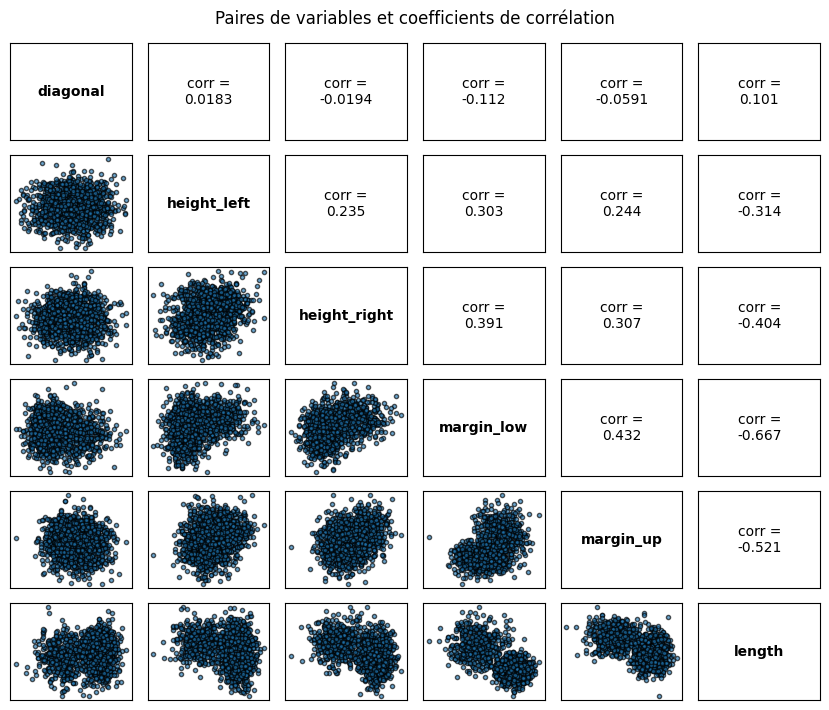

In [202]:
pairplot_correlation(df_billets_sans_na)

`margin_low` est plutôt bien corrélée avec les autres variables à l'exception de `diagonal`. Elle est particulièrement corrélée à `length`.

Plusieurs variables explicatives sont corrélées entre elles, il faut donc vérifier la pertinence de toutes les conserver grâce au test du F dont les hypothèses sont :
* H<sub>0</sub> : il n'y a pas de relation significative entre la variable explicative et la variable dépendante si p-value > 5 % ;
* H<sub>1</sub> : il y a une relation significative entre la variable explicative et la variable dépendante si p-value < 5 %.

In [203]:
# Réalise le test du F et affiche la p-value
res = f_regression(X, y)
for column, result in zip(X.columns, res[1]):
    print(f'{column} : \t{result:>10.4g}')

del res, column, result

diagonal : 	 1.905e-05
height_left : 	 2.289e-32
height_right : 	 1.159e-54
margin_up : 	 1.922e-67
length : 	8.976e-189


Pour chaque varibale H<sub>0</sub> est rejetée, on les conserve toutes.

### Mise en place et résultats du modèle<a id='2-2'></a>

Avant d'effectuer la régression, Les données sont séparées en :
* une partie « train » sur laquelle sera entraîné le modèle ;
* une partie « test » pour tester les résultats du modèle.

In [204]:
# Sépare les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [205]:
# Effectue la régression
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

# Affiche l'intercept et les coefficients
print(f'intercept : \t{lr.intercept_:>6.3f}')
for column, lr_coeff in zip(X.columns, lr.coef_):
    print(f'{column} : \t{lr_coeff:>6.3f}')

del column, lr_coeff

intercept : 	19.510
diagonal : 	-0.072
height_left : 	 0.187
height_right : 	 0.234
margin_up : 	 0.266
length : 	-0.420


Pour évaluer le modèle, on l'applique aux données « test » puis on calcule une série d'indicateurs.

In [206]:
# Effectue la prédiction sur les données test
y_pred = lr.predict(X_test)

# Calcule et affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']


# Calcule les métriques
r2 = lr.score(X_train, y_train)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred)

# Stocke les métriques dans une liste
lr_metrics_values = []
lr_metrics_values.extend([r2, mse, rmse, mae])

# Affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']

for lr_metric, lr_metric_value in zip(lr_metrics, lr_metrics_values):
    print(f'{lr_metric.upper()} : \t{lr_metric_value:.6f}')

del lr_metrics, lr_metrics_values, mse, rmse, mae, lr_metric, lr_metric_value

R2 : 	0.481499
MSE : 	0.232961
RMSE : 	0.482661
MAE : 	0.368762


Le coefficient R² indique que le modèle explique moyennement la variance. A l'inverse, le carré moyen des erreurs (MSE) est plutôt proche de 0 ce qui est une bonne chose car c'est l'une des valeurs que l'on cherche à minimiser dans le cadre d'une régression.

Pour terminer l'analyse, on calule la valeur de R²<sub>ajusté</sub> qui est plus adapté au cas de la régression linéaire multiple. Il se calcule de la manière suivante :

$$R_{ajusté}^2 = 1-[\frac{(1-R^2)\times(n-1)}{n-k-1}]$$
* $n$ : le nombre d'observations ;
* $k$ : le nombre de variables explicatives.

In [207]:
# Calcule R² ajusté
n = len(y_test)
k = len(X_test.columns)
ajusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))

# Affiche la valeur de R² ajusté
print(f'R2 ajusté : {ajusted_r2:.6f}')

del n, k, r2, ajusted_r2

R2 ajusté : 0.476064


La valeur de R²<sub>ajusté</sub> est légèrement inférieure à la valeur de R².

### Fiabilité du modèle<a id='2-3'></a>

Pour s'assurer de la fiabilité du modèle, il faut vérifier plusieurs hypothèses, notamment concernant les résidus qu'il faut donc calculer.

In [208]:
# Calcule les résidus
residuals = y_test - y_pred

#### Hypothèse 1 : linéarité du modèle

La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.

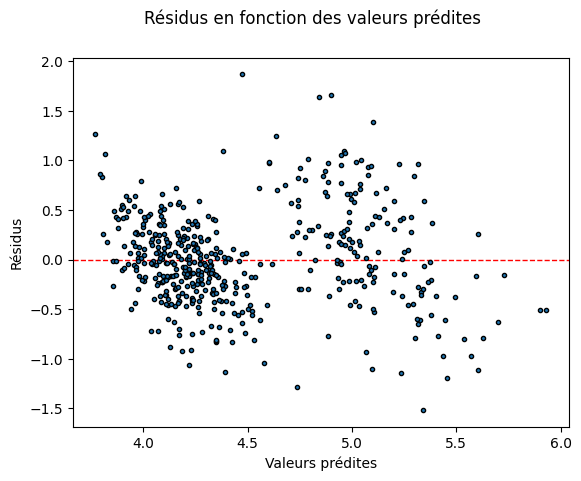

In [209]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=y_pred, y=residuals, marker='.', edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

On n'observe pas de relation linéaire.

#### Hypothèse 2 : indépendance des résidus

Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celui d’un autre. Même si cette hypothèse concerne plutôt les séries temporelles, on peut tout de même tracer les valeurs des résidus en fonction des observations.

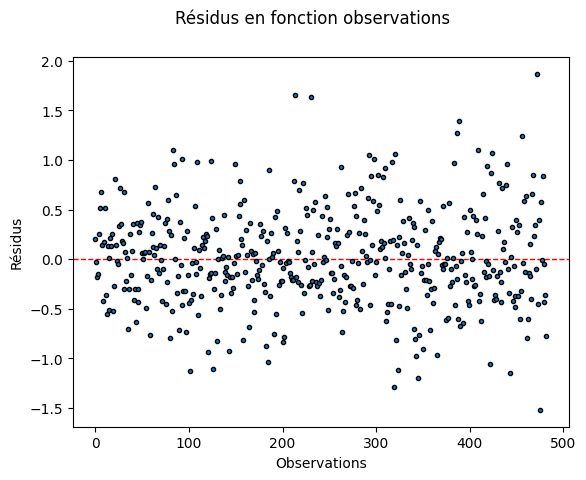

In [210]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=range(len(residuals)), y=residuals, marker='.',
           edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Observations')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction observations')

plt.show()

del fig, ax

Les résidus semblent répartis de manière aléatoire autour de 0. Pour confimer notre observation, on réalise un test de Durbin-Watson. Cette statistique est comprise entre 0 et 4 :
* si sa valeur est **proche de 0**, il y a une **autocorrélation positive** ;
* si sa valeur est **située autour de 2**, il n'y a **pas d’autocorrélation** ;
* si sa valeur est **proche de 4**, il y a une **autocorrélation négative**.

In [211]:
# Calcule et affiche le résultat du test de Durbin-Watson
res = durbin_watson(residuals)
print(f'Durbin-Watson : {res:.3f}')

del res

Durbin-Watson : 2.070


La valeur est proche de 2, il y a donc indépendance des résidus.

#### Hypothèse 3 : homoscédasticité

L'homoscédasticité significie que la variance des résidus est constante. Nous avons constaté précédemment que les résidus étaient dispersés de manière relativement uniforme autour de 0 donc nous pourrions considèrer que l'homoscédasticité est satisfaite. Néanmoins, nous allons réaliser le test statistique de Breush-Pagan dont les hypothèses sont les suivantes :
* H<sub>0</sub> : l’homoscédasticité est présente si p-value > 5 % ;
* H<sub>1</sub> : l’homoscédasticité n’est pas présente si p-value < 5 %.

In [212]:
# Réalise le test de Breush-Pagan
res = het_breuschpagan(residuals, X_test.assign(constant=1))
print(f'p-value : {res[1]:.3e}')

del res

p-value : 1.214e-05


Contrairement aux observations, le test indique que l'homoscédasticité n'est pas présente.

#### Hypothèse 4 : normalité des résidus

Les valeurs des résidus doivent suivre une loi normale. On trace la distribution des résidus.

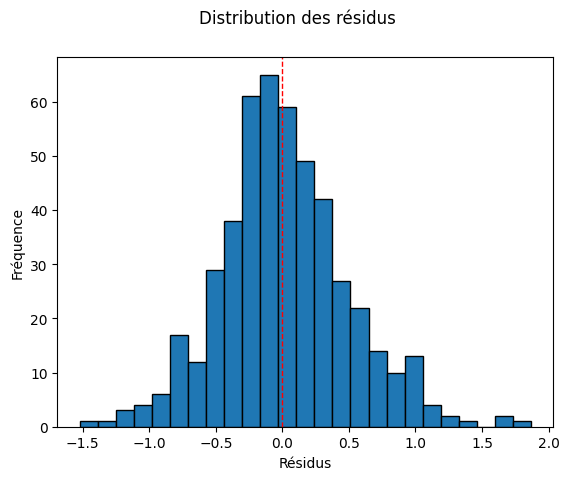

In [213]:
# Trace le graphique
fig, ax = plt.subplots()

ax.hist(x=residuals, bins=25, edgecolor='k')
ax.axvline(x=0, linestyle='--', linewidth=1, color='r')

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

On observe un décalage sur la gauche mais, à priori, la distribution proche de la normalité. Nous allons réaliser un test de Shapiro-Wilk ayant les hypothèses suivantes :
* H<sub>0</sub> : La normalité est vérifiée si p-value > 5 % ;
* H<sub>1</sub> : La normalité n'est pas vérifiée si p-value < 5 %.

In [214]:
# Réalise le test de Shapiro-Wilk
res = stats.shapiro(residuals)
print(f'p-value : {res.pvalue:.3e}')

del res

p-value : 1.654e-03


Là aussi, contrairement aux observations le test n'est pas concluant.

#### Hypothèse 5 : pas de colinéarité

Les variables explicatives ne doivent pas être fortement corrélées entre elles, or, nous avions observé quelques coefficients de corrélation assez élevés. Afin de déterminer si cette hypothèse est validée, nous allons calculer le « VIF » (facteur d'inflation de variance) pour chaque variable explicative :
* si **VIF = 1** : **pas de corrélation** entre les variables explicatives ;
* si **1 < VIF ≤ 5** : il y a une **corrélation modérée** mais ne nécessite pas forcément une attention particulière ;
* si **VIF > 5** : il y a une **corrélation importante** qui peut nuire au résultat de la régression.

Le VIF se calcule de la manière suivante :

$$VIF_i = \frac{1}{1-R_i^2}$$
* $R_i^2$ : valeur de $R^2$ de la regression pour chaque variable explicative considérée comme dépendante.

In [215]:
# Calcule le VIF pour chaque variable explicative considérée dépendante
for column in X_train.columns:
    y_vif = X_train[column]
    X_vif = X_train.drop(columns=column)
    lr_vif = LinearRegression().fit(X_vif, y_vif)
    r2_vif = lr_vif.score(X_vif, y_vif)
    vif = 1 / (1 - r2_vif)
    print(f'{column} : \t{vif:.3f}')

del column, y_vif, X_vif, lr_vif, r2_vif, vif

diagonal : 	1.006
height_left : 	1.167
height_right : 	1.206
margin_up : 	1.451
length : 	1.597


Toutes les valeurs sont proches de 1, il n'y a donc pas de problème de colinéarité.

### Prédiction des valeurs manquantes<a id='2-4'></a>

Grâce au modèle mis en place, on prédit les valeurs manquantes des enregistrements incomplets puis on reconstitue le jeu de données complet.

In [216]:
# Copie les enregistrements contenant les valeurs manquantes
df_billets_na = df_billets[df_billets.isna().any(axis='columns')].copy()

# Prédit les valeurs manquantes grâce au modèle
df_billets_na['margin_low'] = lr.predict(
    df_billets_na.drop(columns=['is_genuine', 'margin_low']))

# Concatène les enregistrements avec et sans valeurs manquantes
df_billets = pd.concat([df_billets_sans_na, df_billets_na]).sort_index()

del (df_billets_sans_na, df_billets_na, X, y, X_train, y_train, X_test,
     y_test, y_pred, lr, residuals)

## Analyse descriptive<a id='3'></a>

### Analyse univariée<a id='3-1'></a>

In [217]:
# Affiche un aperçu des données
df_billets.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
264,True,171.75,104.12,104.10,3.85,3.24,113.30
556,True,171.83,104.54,103.91,4.11,3.05,113.55
19,True,171.90,103.67,103.15,4.55,3.15,113.12
111,True,172.03,103.96,103.58,4.06,2.85,113.02


In [218]:
# Affiche un résumé du DataFrame
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


Il n'y a plus de valeurs manquantes.

In [219]:
# Affiche une description synthétique des données numériques
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483320,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659744,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les données semblent plutôt homogènes :
* les moyennes et les médianes sont proches ;
* les valeurs minimales et maximales sont proches des moyennes.

In [220]:
# Affiche le nombre de vrais/faux billets
df_billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Le jeu de données comprend 2/3 de billets authentiques et 1/3 de faux billets.

In [221]:
# Affiche la moyenne et la médiane des variables pour les vrais et faux billets
df_billets.groupby('is_genuine').agg({'mean', 'median'}).round(3).stack()

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                      
False      mean     171.901      104.190       104.144       5.214      3.350   
           median   171.910      104.180       104.160       5.180      3.350   
True       mean     171.987      103.949       103.809       4.118      3.052   
           median   171.990      103.950       103.810       4.120      3.050   

                    length  
is_genuine                  
False      mean    111.631  
           median  111.630  
True       mean    113.202  
           median  113.205

Pour chaque variable les moyennes et les médianes sont proches. `margin_low` est la variable dont la moyenne et la médiane diffèrent le plus en fonction de l'authenticité des billets. Traçons la dispersion et la distribution des variables.

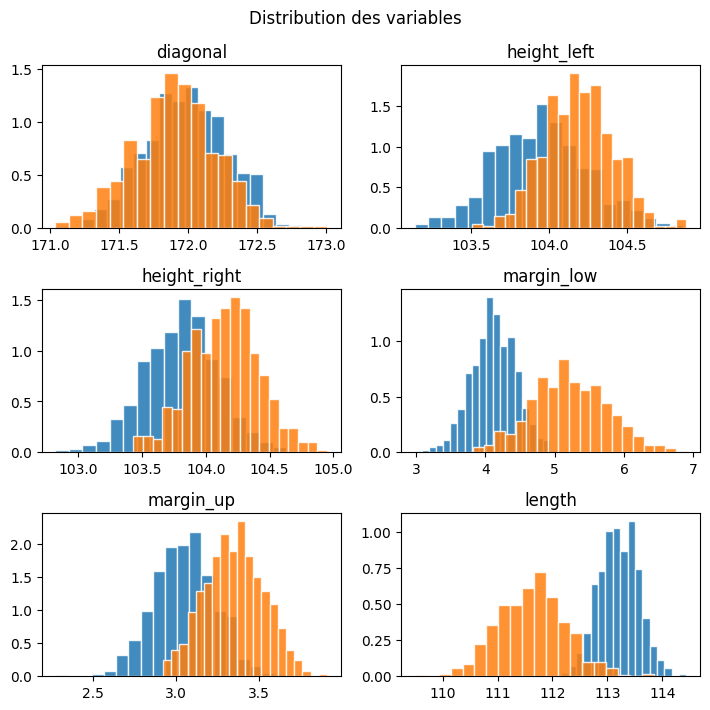

In [222]:
# Liste les valeurs de 'is_genuine'
is_genuine_values = df_billets['is_genuine'].unique()

# Trace les histogrammes de chaque variable
fig, axs = plt.subplots(3, 2, figsize=(7.2, 7.2))
axs = axs.flatten()

for i, column in enumerate(df_billets.columns[1:]):
    for j, is_genuine_value in enumerate(is_genuine_values):
        axs[i].hist(df_billets.loc[df_billets['is_genuine'] == is_genuine_value, column], alpha=0.85, bins=20, edgecolor='w', density=True)
        axs[i].set_title(column)

fig.suptitle('Distribution des variables')

fig.tight_layout()

plt.show()

del is_genuine_values, fig, axs, i, column, j, is_genuine_value

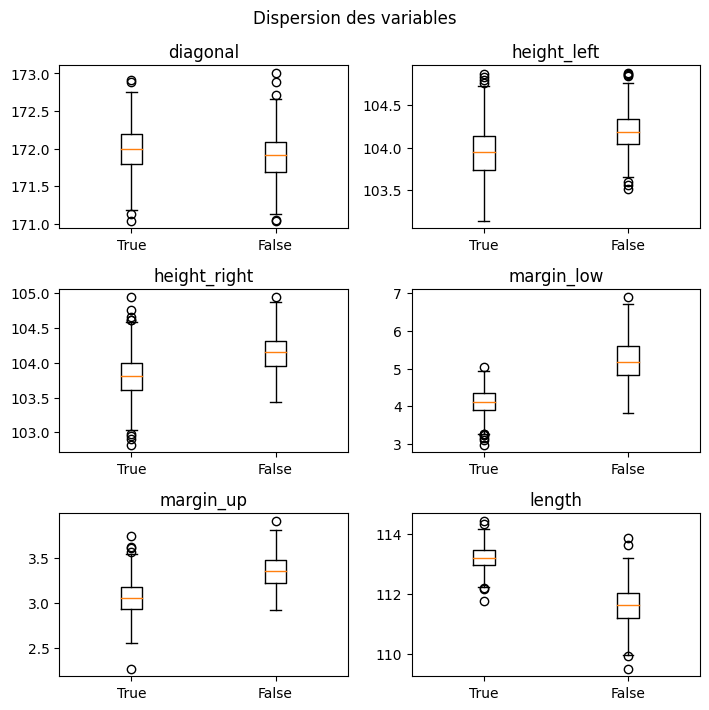

In [223]:
# Liste les valeurs de 'is_genuine'
is_genuine_values = df_billets['is_genuine'].unique()

# Trace les boxplots de chaque variable
fig, axs = plt.subplots(3, 2, figsize=(7.2, 7.2))
axs = axs.flatten()

for i, column in enumerate(df_billets.columns[1:]):
    for j, is_genuine_value in enumerate(is_genuine_values):
        axs[i].boxplot(df_billets.loc[df_billets['is_genuine'] == is_genuine_value, column], positions=[j])
        axs[i].set_title(column)
        
    axs[i].set_xticklabels(is_genuine_values)

fig.suptitle('Dispersion des variables')

fig.tight_layout()

plt.show()

del is_genuine_values, fig, axs, i, column, j, is_genuine_value

Les différences dimensionnelles entre les vrais et les faux billets sont plus visibles : `diagonal` est assez similaire tandis que `margin_low` et `length` sont très différentes. Nous allons afficher les paires de variables mais en les différenciant en fonction de l'authenticité.

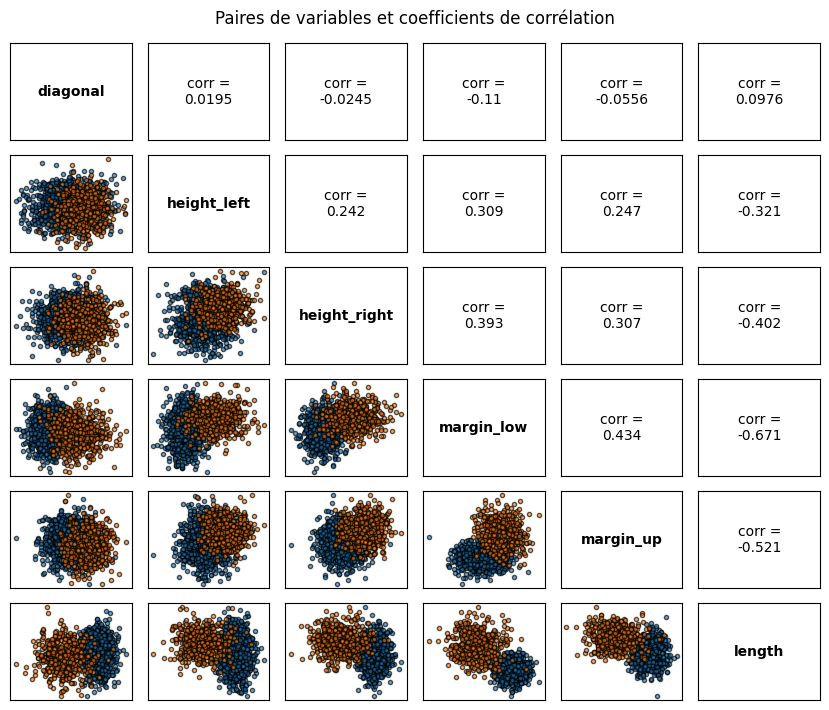

In [224]:
# Trace les variables quantitatives par paires
pairplot_correlation(df_billets, hue='is_genuine')

On visualise assez bien deux groupes distincts, notamment pour les variables les plus corrélées entre elles.

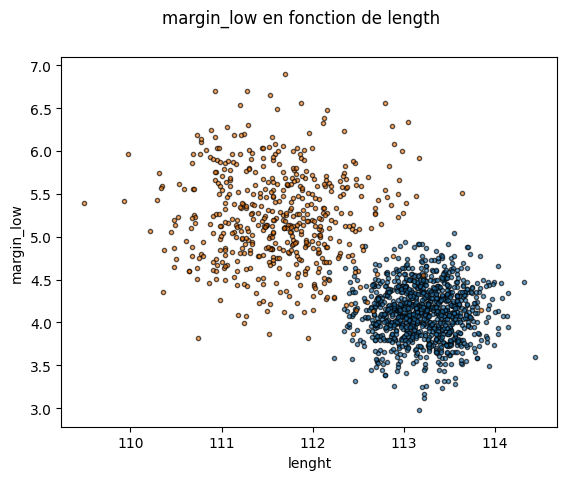

In [225]:
# Trace 'margin_low' et 'length'
fig, ax = plt.subplots()

ax.scatter(data=df_billets[df_billets['is_genuine'] == True],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)
ax.scatter(data=df_billets[df_billets['is_genuine'] == False],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('margin_low en fonction de length')

plt.show()

del fig, ax

Pour finir, on affiche la matrice de corrélation **en incluant `is_genuine`**.

In [226]:
# Calcule la matrice de corrélation
df_billets.corr().style.background_gradient(axis=None, cmap='RdYlGn')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783519,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.110162,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.309326,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.393195,0.307005,-0.401751
margin_low,-0.783519,-0.110162,0.309326,0.393195,1.000000,0.434422,-0.671192
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.434422,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.671192,-0.520575,1.000000


Les variables les plus corrélées à `is_genuine` sont celles qui sont les plus corrélées entre elles. On peut supposer que ces variables joueront un rôle déterminant dans l'algorithme de détection.

## Construction de l'algorithme de détection<a id='4'></a>

### Prétraitement<a id='4-1'></a>

L'algorithme doit détecter les faux billets, or la variable dont nous disposons est `is_genuine`. Cela signifie que quand sa valeur est vraie, le billet est authentique. Par choix, nous allons préférer que notre variable cible soit vraie lorsqu'un faux billet est détecté. De plus, nous allons la convertir en valeur numérique.

In [227]:
# Tranforme 'is_genuine' en 'is_fake' avec des valeurs numériques
df_billets = df_billets.rename(columns={'is_genuine': 'is_fake'})
df_billets['is_fake'] = df_billets['is_fake'].map({True: 0, False: 1})

df_billets.head(3)

,is_fake,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,171.81,104.86,104.95,4.52,2.89,112.83
1,0,171.46,103.36,103.66,3.77,2.99,113.09
2,0,172.69,104.48,103.50,4.40,2.94,113.16


Puis on définit les variables et la cible et on sépare les données en entrainement et en test.

In [228]:
# Définit X et y
X = df_billets.drop(columns='is_fake')
y = df_billets['is_fake']

# Sépare les données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Pour comparer les résultats des différentes méthodes de classification, nous définissons une fonction qui va sauvegarder les métriques.

In [229]:
def save_classifier_metrics(y_true, y_pred, clf_label, pos_label):
    '''Sauvegarde et affiche les métriques dans un dictionnaire.
    Paramètres :
    - y_true : la vraie valeur des labels
    - y_pred : les labels prédits par la méthode de classification
    - clf_label : le nom de la méthode de classification
    - pos_label : le label de la classe positive
    '''

    if not('clf_metrics_dict' in globals()):  
        global clf_metrics_dict
        clf_metrics_dict = {
            'accuracy': {}, 'precision': {}, 'recall': {}, 'f1-score': {}}
        
    clf_metrics_dict['accuracy'].update(
        {clf_label: metrics.accuracy_score(y_true, y_pred)})
    
    clf_metrics_dict['precision'].update(
        {clf_label: metrics.precision_score(
            y_true, y_pred, pos_label=pos_label)}
    )
    
    clf_metrics_dict['recall'].update(
        {clf_label: metrics.recall_score(
            y_true, y_pred, pos_label=pos_label)}
    )
    
    clf_metrics_dict['f1-score'].update(
        {clf_label: metrics.f1_score(
            y_true, y_pred, pos_label=pos_label)}
    )

    return pd.DataFrame(clf_metrics_dict)

### Méthode 1 : Régression logistique<a id='4-2'></a>

La régression logistique est une méthode de classification supervisée dont l'objectif est de modéliser les relations entre une variable binaire en fonction de variables généralement quantitatives. Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. 

#### Régression sans optimisation<a id='4-2-1'></a>

In [230]:
# Effectue la régression
clf_log_reg = LogisticRegression()
clf_log_reg.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_log_reg.predict(X_test)

# Affiche les coefficients de la régression
for column, coef in zip(X.columns, clf_log_reg.coef_[0]):
    print(f'{column} : \t{coef:>9.6f}')

del column, coef

diagonal : 	 0.159883
height_left : 	 1.605045
height_right : 	 1.880435
margin_low : 	 3.188571
margin_up : 	 2.778681
length : 	-3.679474


L'analyse des coefficients donne des résultats cohérents avec le nuage de points tracé à la fin de la partie précédente avec `length` et `margin_low`. Plus les billets sont longs, plus ils sont authentiques, et plus leur marge basse est grande, plus ils sont faux.

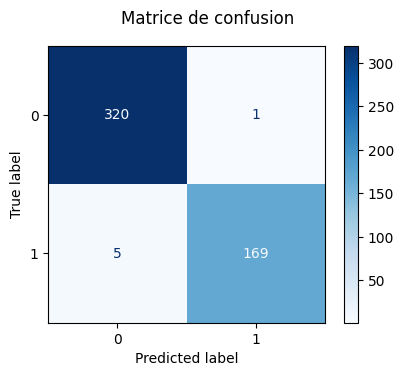

In [231]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

La matrice de confusion permet de décrire les performances du modèle :
* Les **vrais positifs** : pour *169 billets*, nous avons *correctement* prédit qu'ils sont *faux*.
* Les **vrais négatifs** : pour *320 billets*, nous avons *correctement* prédit qu'ils sont *authentiques*.
* Les **faux positifs** : pour *1 billet*, nous avons prédit *à tort* qu'il n'est pas *authentiques*.
* Les **faux négatifs** : pour *5 billets*, nous avons prédit *à tort* qu'ils sont *authentique*.

A partir de la mtatrice, il est possible de calculer différents métriques intégrés dans le module `sklearn.metrics`.

|Métrique         |Définition                                                                                            |
|:----------------|:-----------------------------------------------------------------------------------------------------|
|*precision*      |Mesure la capacité du modèle à détecter l’ensemble des individus d'une classe en particulier          |
|*recall*         |Mesure la capacité du modèle à ne pas faire d’erreur lors d’une prédiction d'une classe en particulier|
|*accuracy*       |Mesure le taux de prédictions correctes sur l'ensemble des individus positifs et négatifs             |
|*f1-score*       |Le F1-score permet de résumer les valeurs de *precision* et de *recall* en une seule métrique         |

Il est important que l'algorithme soit plus précis sur la détection des faux billets que sur celle des vrais billets : **il est moins problématique de détecter un billet authentique comme étant faux que l'inverse**. Ce sont donc les métriques des faux billets que nous souhaitons conserver.

In [232]:
save_classifier_metrics(y_test, y_pred, 'logistic regression', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [233]:
del y_pred

#### Optimisation avec `GridSearchCV`<a id='4-2-2'></a>

Essayons d'améliorer notre modèle en optimisant le choix des paramètres de la régression grâce à `GridSearchCV`. Nous n'allons pas changer le *solver* qui est adapté à la taille et à la complexité du jeu de données et nous laissons donc `penalty=l2`. Seul `C` va finalement varier. Ce paramètre agit sur la manière dont `penalty` va essayer de réduire l'*overfitting*.

`GridSearchCV` effectue également une validation croisée qui exécute le processus de modélisation sur différents sous-ensembles de données afin d'obtenir plusieurs mesures de la qualité du modèle et ainsi s'assurer de sa qualité.

In [234]:
# Crée le 'f1-score' des faux billets comme métrique
scoring = metrics.make_scorer(metrics.f1_score, pos_label=1)

# Définit les paramètres et valeurs à tester
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

# Exécute GridSearchCV avec la régression logistique
clf_log_reg_gs = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5
)
clf_log_reg_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_log_reg_gs.best_params_)

del param_grid

{'C': 100}


La valeur optimale serait donc `C=100`. Refaisons la regression logistique avec ce paramètre.

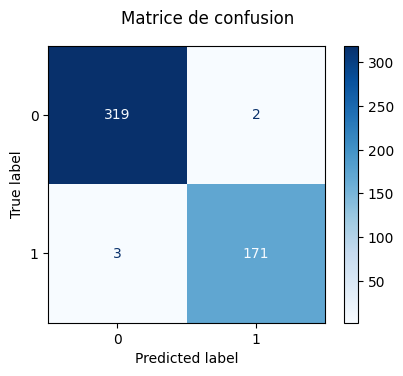

In [235]:
# Effectue la régression avec C=100
clf_log_reg_gs = LogisticRegression(C=100, max_iter=100)
clf_log_reg_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_log_reg_gs.predict(X_test)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [236]:
save_classifier_metrics(y_test, y_pred, 'logistic regression + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [237]:
del y_pred

### Méthode 2 : k-means<a id='4-3'></a>

#### k-means sans optimisation<a id='4-3-1'></a>

La classification k-means est un algorithme non supervisé principalement utilisé pour le *clustering*. Dans le cadre de notre analyse, nous allons à priori avoir seulement deux *clusters* (vrais et faux billets). En cherchant à savoir à quel groupe appartient un billet, nous pourrons donc prédire sa classe.

La première étape consiste à normaliser les données d'entraînement.

In [238]:
# Standardise les données test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Pour confirmer que seuls deux *clusters* sont nécessaires, nous allons utiliser la méthode du coude et celle du score de Silhouette.

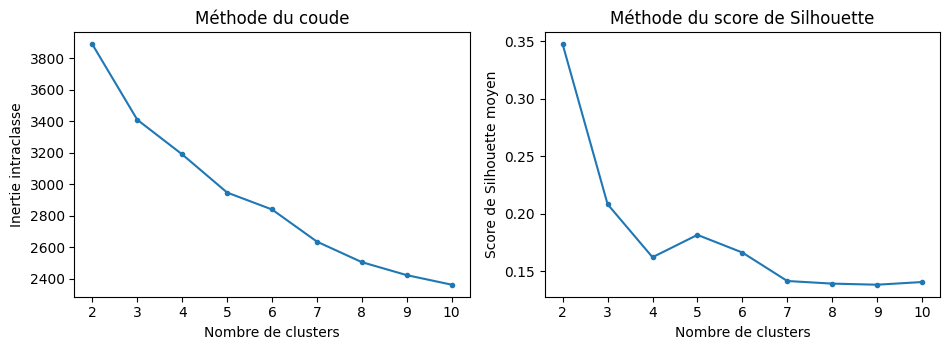

In [239]:
# Initialise les variables
n_clusters_range = range(2, 11)
inertias=[]
silhouette_avg_scores = []

# Calcul l'inertie et les score de silhouette moyen pour chaque valeur
# du nombre de clusters
for n_clusters in n_clusters_range:
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='k-means++')
    clustering = clustering.fit(X_train_scaled)
    
    inertias.append(clustering.inertia_)

    silhouette_avg = metrics.silhouette_score(
        X_train_scaled, clustering.labels_)
    silhouette_avg_scores.append(silhouette_avg)

# Trace les graphiques
fig, axs = plt.subplots(1, 2, figsize=(9.6, 3.6))

axs[0].plot(n_clusters_range, inertias, marker='.')
axs[1].plot(n_clusters_range, silhouette_avg_scores, marker='.')

# Définie la position des graduations
axs[0].xaxis.set_major_locator(ticker.IndexLocator(1, 0))
axs[1].xaxis.set_major_locator(ticker.IndexLocator(1, 0))

# Définie les titres des graphiques et de leurs axes
axs[0].set_xlabel('Nombre de clusters')
axs[0].set_ylabel('Inertie intraclasse')
axs[0].set_title('Méthode du coude')
axs[1].set_xlabel('Nombre de clusters')
axs[1].set_ylabel('Score de Silhouette moyen')
axs[1].set_title('Méthode du score de Silhouette')

fig.tight_layout()

plt.show()

del (n_clusters_range, inertias, silhouette_avg, silhouette_avg_scores,
     n_clusters, clustering, fig, axs)

La méthode du coude ne permet pas de définir facilement le nombre de *clusters* optimal car on n'observe pas de point à partir duquel l'inertie évolue de manière linéaire.

C'est pour deux *clusters* que le score de Silhouette moyen est le meilleur, mais cela est souvent le cas. Le score diminue au fûr et à mesure que le nombre de *clusters* augmente, il n'y a donc pas de raison de choisir plus de groupes que deux.

In [240]:
# Effectue le clustering avec 2 clusters
clf_kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto',
                    random_state=42)
clf_kmeans.fit(X_train_scaled)

KMeans(n_clusters=2, n_init='auto', random_state=42)

On normalise les données à tester avant de faire la prédiction, mais attention, on applique uniquement la méthode `transform` sans `fit` contrairement à ce que nous avions fait pour les données d'entraînement.

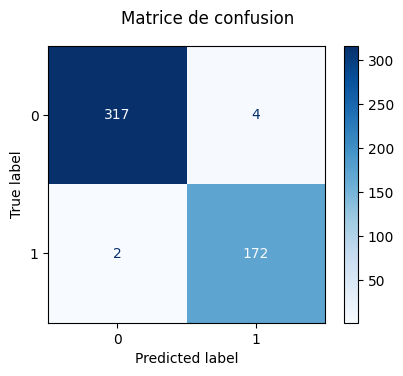

In [241]:
# Normalise les données test
X_test_scaled = scaler.transform(X_test)

# Effectue la prédiction sur les données test
y_pred = clf_kmeans.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

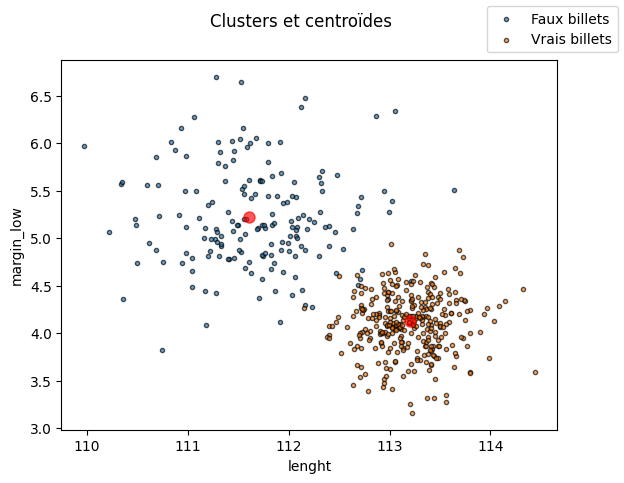

In [242]:
# Trace les clusters et leur centroïde avec 'margin_low' et 'length'
df_temp = X_test.copy()
df_temp['cluster'] = y_pred

fig, ax = plt.subplots()

ax.scatter(data=df_temp[df_temp['cluster'] == 1],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)
ax.scatter(data=df_temp[df_temp['cluster'] == 0],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65)

ax.plot(scaler.inverse_transform(clf_kmeans.cluster_centers_)[1][5],
        scaler.inverse_transform(clf_kmeans.cluster_centers_)[1][3],
        marker='o', markersize=8, color='r', alpha=0.65)

ax.plot(scaler.inverse_transform(clf_kmeans.cluster_centers_)[0][5],
        scaler.inverse_transform(clf_kmeans.cluster_centers_)[0][3],
        marker='o', markersize=8, color='r', alpha=0.65)

ax.set_xlabel('lenght')
ax.set_ylabel('margin_low')

fig.suptitle('Clusters et centroïdes')

fig.legend(['Faux billets', 'Vrais billets'])

plt.show()

del fig, ax, df_temp

In [243]:
save_classifier_metrics(y_test, y_pred, 'k-means', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [244]:
del y_pred

#### Validation croisée `cross_validate`<a id='4-3-2'></a>

On vérifie la qualité de la classification k-means grâce à la validation croisée.

In [245]:
# Standardise les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Calcul 'accuracy' pour 5 'folds'
scores = cross_val_score(
    KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42),
    X_train_scaled, y_train, cv=5, scoring=scoring
)

# Affiche les résulatats
print(
    f'f1-score_fake\n'
    f'min. :\t{np.min(scores):.6f}\n'
    f'max. :\t{np.max(scores):.6f}\n'
    f'moy. :\t{np.average(scores):.6f}'
)

del scores

f1-score_fake
min. :	0.958678
max. :	0.983333
moy. :	0.973659


Les résultats montrent que la qualité du modèle varie en fonction des données, on peut donc mettre en doute sa qualité.

In [246]:
del scaler, X_train_scaled, X_test_scaled

### Méthode 3 : k-nearest neighbors (kNN)<a id='4-4'></a>

L'algorithme KNN (*K-nearest neighbors*) est une méthode supervisé utilisé pour la régression ou la classification. Il se base sur la distance entre observations voisines.

#### kNN sans optimisation<a id='4-4-1'></a>

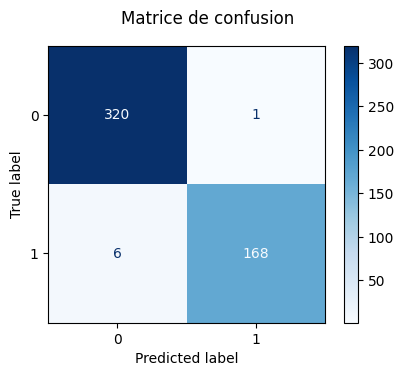

In [247]:
# Standardise les données test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Effectue les kNN
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train_scaled, y_train)

# Normalise les données test
X_test_scaled = scaler.transform(X_test)

# Effectue la prédiction sur les données test
y_pred = clf_knn.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [248]:
save_classifier_metrics(y_test, y_pred, 'knn', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [249]:
del y_pred

#### Optimisation avec `GridSearchCV`<a id='4-4-2'></a>

On utilise `GridSearchCV` pour chercher les meilleurs paramètres.

In [250]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'n_neighbors' : np.arange(1, 100, 3)
}

# Exécute GridSearchCV avec kNN
clf_knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_knn_gs.fit(X_train_scaled, y_train)

# Affiche le meilleur paramètre
print(clf_knn_gs.best_params_)

del param_grid

{'n_neighbors': 7}


Puis on relance l'algorithme avec ces nouveaux paramètres.

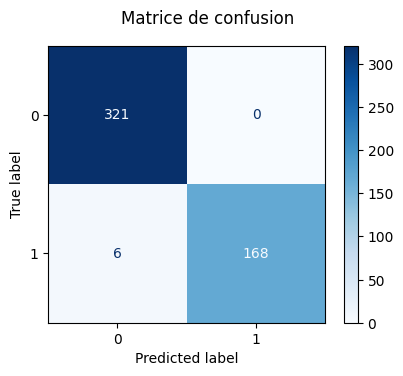

In [251]:
# Effectue les kNN
clf_knn_gs = KNeighborsClassifier(n_neighbors=7)
clf_knn_gs.fit(X_train_scaled, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_knn_gs.predict(X_test_scaled)

# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [252]:
save_classifier_metrics(y_test, y_pred, 'knn + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [253]:
del y_pred, scaler, X_train_scaled, X_test_scaled

### Méthode 4 : arbre de décision<a id='4-5'></a>

L'arbre de décision est une méthode d'apprentissage supervisé utilisée pour la classification et la régression. L'objectif est de créer un modèle qui prédit la valeur d'une variable cible en apprenant des règles de décision simples déduites des caractéristiques des données. Une série de décisions séquentielles (« si-alors ») sont prises en fonction des caractéristiques des données créant ainsi une structure en arboresence.

#### Arbre sans optimisation<a id='4-5-1'></a>

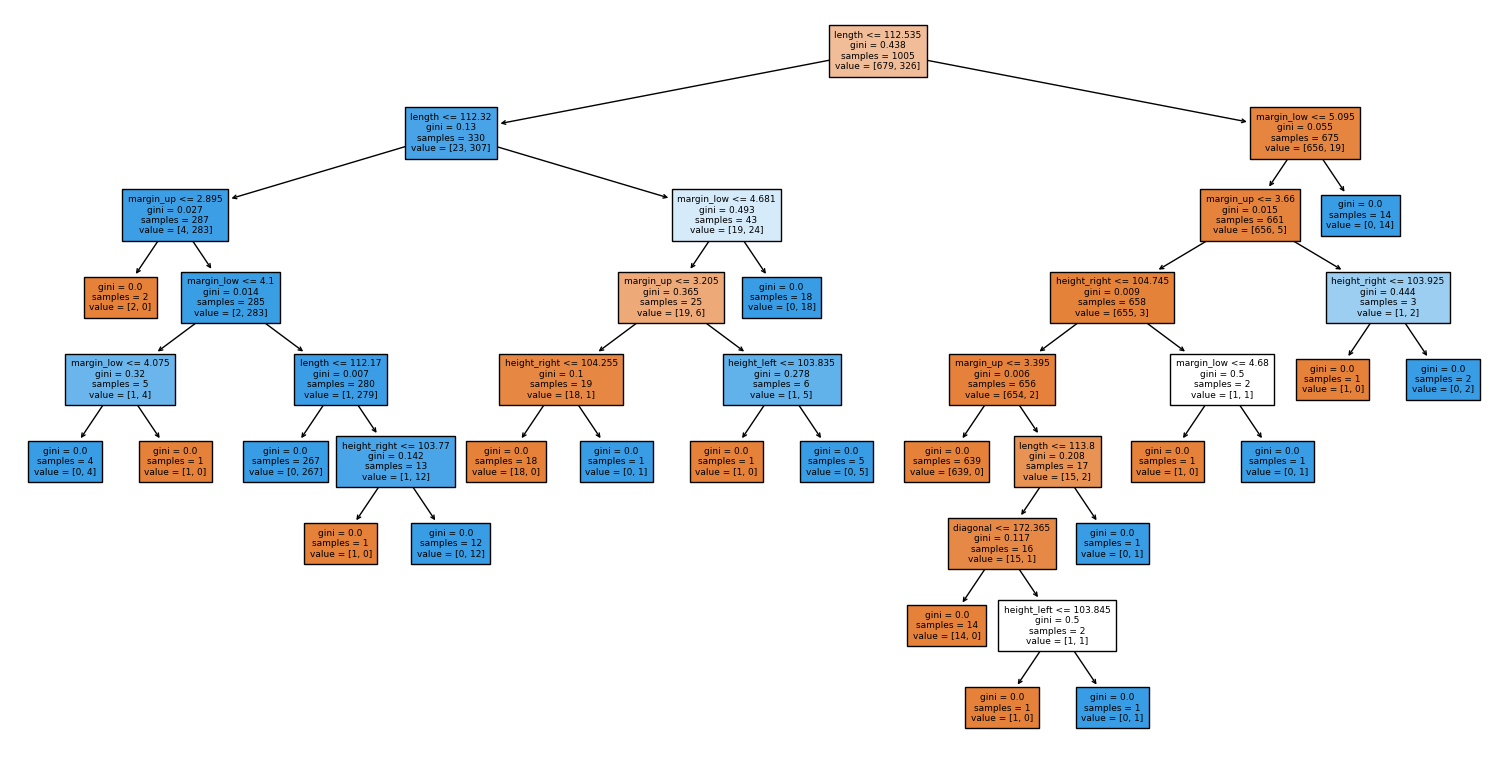

In [254]:
# Effectue l'arbre de décision
clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_tree.predict(X_test)

# Affiche l'arbre
fig, ax = plt.subplots(figsize=(19.2, 9.6))
plot_tree(clf_tree, feature_names=X.columns, filled=True, fontsize=6.5, ax=ax)
plt.show()

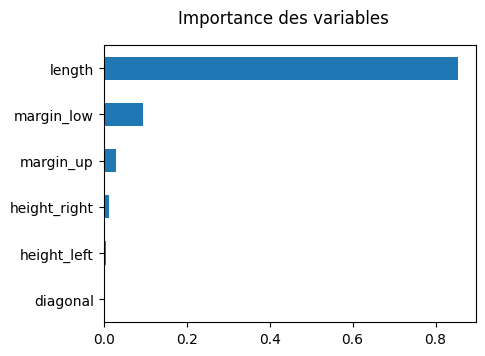

In [255]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_tree.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

Le graphique correspondant bien à l'analyse descriptive où notamment `diagonal` était très proche pour les vrais et les faux billets. Il est donc logique que sont importance soit assez faible dans la prise de décision.

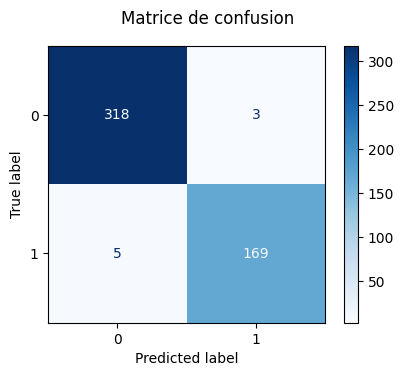

In [256]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [257]:
save_classifier_metrics(y_test, y_pred, 'decision tree', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [258]:
del y_pred

#### Optimisation avec `GridSearchCV`<a id='4-5-2'></a>

On utilise `GridSearchCV` pour chercher les meilleurs paramètres.

In [259]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'max_depth' : np.arange(start=1, stop=10, step=1),
    'min_samples_leaf' : np.arange(start=5, stop=250, step=50),
    'min_samples_split' : np.arange(start=10, stop=500, step=50)
}

# Exécute GridSearchCV avec l'arbre de décision
clf_tree_gs = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_tree_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_tree_gs.best_params_)

del param_grid

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10}


Puis on effectue la classification avec ces nouveaux paramètres.

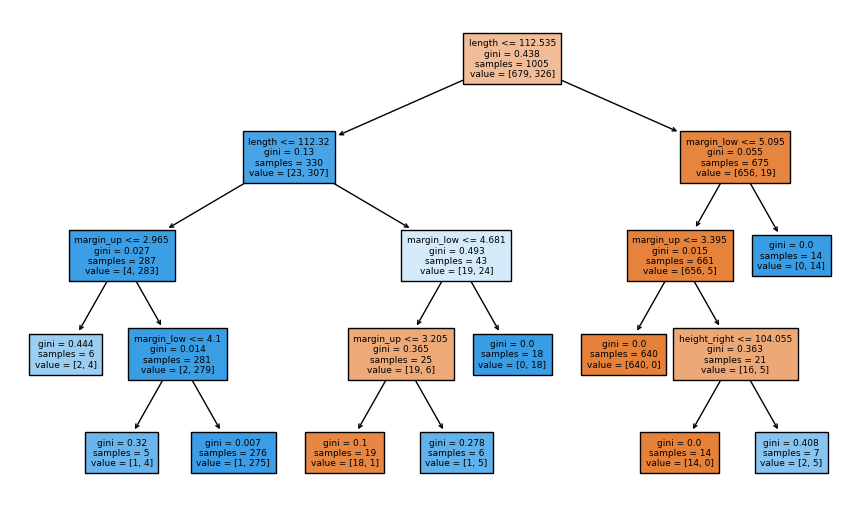

In [260]:
# Effectue l'arbre de décision
clf_tree_gs = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=5, min_samples_split=10)
clf_tree_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_tree_gs.predict(X_test)

# Affiche l'arbre
fig, ax = plt.subplots(figsize=(10.8, 6.4))
plot_tree(clf_tree_gs, feature_names=X.columns, filled=True, fontsize=6.5, ax=ax)
plt.show()

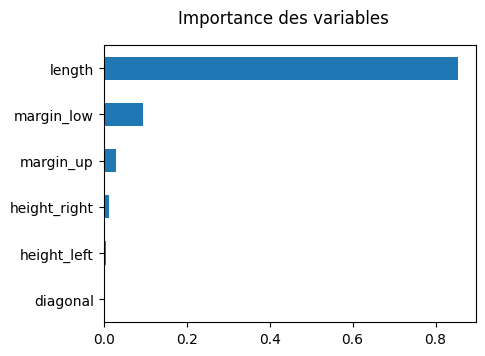

In [261]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_tree.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

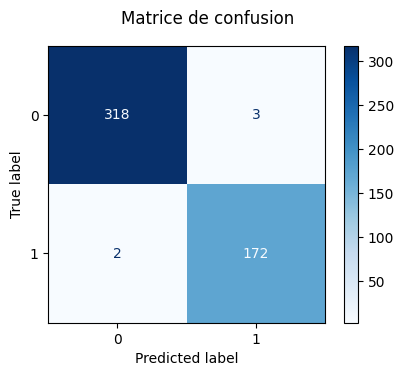

In [262]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [263]:
save_classifier_metrics(y_test, y_pred, 'decision tree + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [264]:
del y_pred

### Méthode 5 : forêt aléatoire<a id='4-6'></a>

La forêt aléatoire est un algorithme d’apprentissage supervisé qui compile de résultat de plusieurs arbres de décision formés de manière alétaoire.

#### Forêt sans optimisation<a id='4-6-1'></a>

In [265]:
# Effectue la forêt aléatoire
clf_forest = RandomForestClassifier(max_depth=2, random_state=0)
clf_forest.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_forest.predict(X_test)

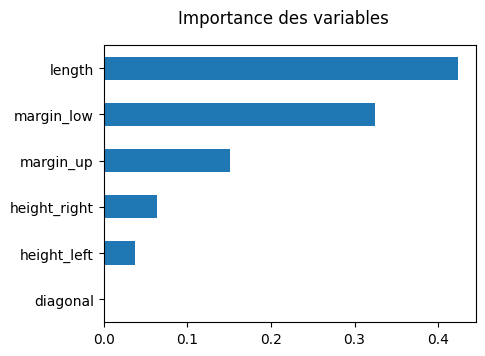

In [266]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_forest.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

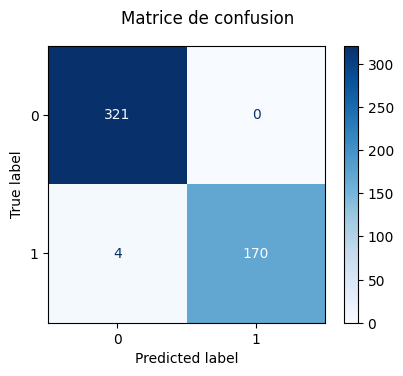

In [267]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [268]:
save_classifier_metrics(y_test, y_pred, 'random forest', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [269]:
del y_pred

#### Optimisation avec `GridSearchCV`<a id='4-6-2'></a>

In [270]:
# Définit les paramètres et valeurs à tester
param_grid = {
    'n_estimators': np.arange(start=1, stop=6, step=1),
    'max_depth': np.arange(start=1, stop=6, step=1),
    'min_samples_leaf': np.arange(start=5, stop=50, step=10),
    'min_samples_split': np.arange(start=10, stop=100, step=50)
}

# Exécute GridSearchCV avec l'arbre de décision
clf_forest_gs = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid=param_grid, scoring=scoring, cv=5)
clf_forest_gs.fit(X_train, y_train)

# Affiche le meilleur paramètre
print(clf_forest_gs.best_params_)

del param_grid

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 5}


In [271]:
# Effectue la forêt aléatoire
clf_forest_gs = RandomForestClassifier(
    n_estimators=5, max_depth=4, min_samples_leaf=5, min_samples_split=10,
    random_state=0
)
clf_forest_gs.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_forest_gs.predict(X_test)

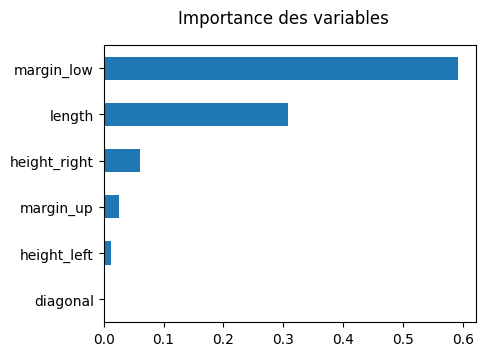

In [272]:
# Trace les variables en fonction de leur importance
fig, ax = plt.subplots(figsize=(4.8, 3.6))

pd.DataFrame(
    clf_forest_gs.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance').plot.barh(ax=ax)

ax.get_legend().remove()

fig.suptitle('Importance des variables')

plt.show()

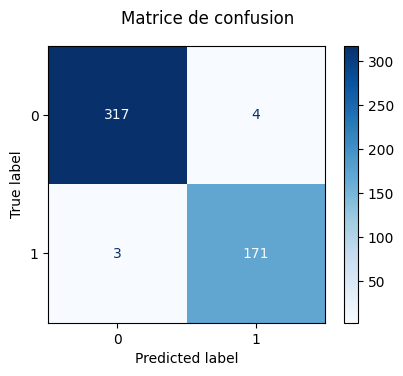

In [273]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [274]:
save_classifier_metrics(y_test, y_pred, 'random forest + gridsearch', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [275]:
del y_pred

### Méthode 6 : *Bagging*<a id='4-7'></a>

Le *bagging* est un méta-algorithme faisant partie des méthodes ensemblistes pouvant être utilisé en régression comme en classification. Il utilise de multiples fois un algorithme pour obtenir un résultat plus fiable en réalisant un échantillonnage des données et en l'entraînant de façon séparée sur chacun de ces échantillons. Il assemble ensuite les résultats des modèles obtenus.

In [276]:
# Effectue le baggin avec l'arbre de décision
clf_bagging = BaggingClassifier(
    DecisionTreeClassifier(
        max_depth=4, min_samples_leaf=5, min_samples_split=10),
        n_estimators=50, random_state=0
)
clf_bagging.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_bagging.predict(X_test)

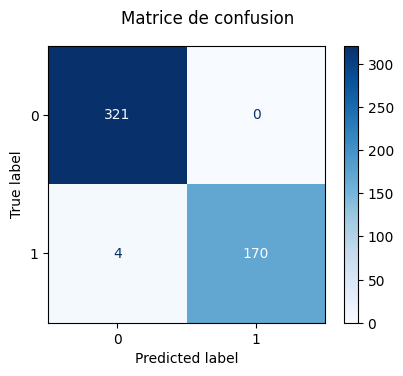

In [277]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [278]:
save_classifier_metrics(y_test, y_pred, 'bagging', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


In [279]:
del y_pred

### Méthode 7 : *Boosting*<a id='4-8'></a>

Le *boosting* se base sur le même principe que le *bagging* sans la dimension aléatoire. Il tient du résultat d'un modèle et surtout de ses erreurs pour améliorer les performances en formant un nouveau modèle qui réussisse à prédire les erreurs faites par le modèle original.

In [280]:
# Effectue le Boosting
clf_boosting = GradientBoostingClassifier(
    max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50,
    random_state=0
)
clf_boosting.fit(X_train, y_train)

# Effectue la prédiction sur les données test
y_pred = clf_boosting.predict(X_test)

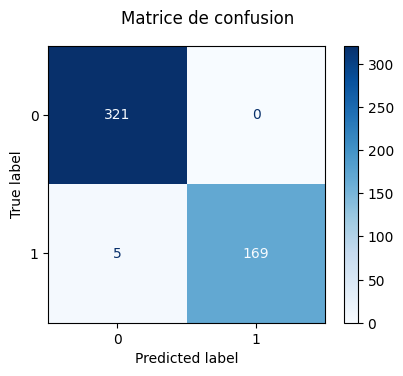

In [281]:
# Trace la matrice de confusion
fig, ax = plt.subplots(figsize=(4.8, 3.6))

metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, ax=ax, cmap='Blues')

fig.suptitle('Matrice de confusion')

plt.show()

del fig, ax

In [282]:
save_classifier_metrics(y_test, y_pred, 'boosting', 1)

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


## Choix de l'agorithme<a id='5'></a>

In [283]:
pd.DataFrame(clf_metrics_dict).style.background_gradient()

,accuracy,precision,recall,f1-score
logistic regression,0.987879,0.994118,0.971264,0.982558
logistic regression + gridsearch,0.989899,0.988439,0.982759,0.985591
k-means,0.987879,0.977273,0.988506,0.982857
knn,0.985859,0.994083,0.965517,0.979592
knn + gridsearch,0.987879,1.000000,0.965517,0.982456
decision tree,0.983838,0.982558,0.971264,0.976879
decision tree + gridsearch,0.989899,0.982857,0.988506,0.985673
random forest,0.991919,1.000000,0.977011,0.988372
random forest + gridsearch,0.985859,0.977143,0.982759,0.979943
bagging,0.991919,1.000000,0.977011,0.988372


Dans le cadre de ce projet, notre sélection portera uniquement sur la **régression logistique** ou les **k-means** :
* La **régression logistique** optimisée grâce à ***GridSearchCV*** est la méthode où les résultats sont les plus homogènes. Elle a un taux de prédiction élevé sur l'ensemble des échantillons, une bonne capacité à détecter les faux billets et à ne pas faire d'erreurs lorsqu'elle le fait.
* les **k-means** ont une meilleure capacité à ne pas faire d'erreurs lorsqu'ils prédisent des faux billets, mais sont en dessous de la régression dans les autres domaines. De plus, nous avons vu grâce à la validation croisée que sa qualité pouvait être remise en cause.

<div class='alert alert-block alert-success'>
    &#x1F6C8; L'algorithme retenu est donc celui de la <b>régression logistique optimisée</b>.
</div>

Quelques commentaires sur les résultats des autres algorithmes :
* Les **kNN** avec ***GridSearchCV*** détectent tous les faux billets mais font plus d'erreurs que la **régression logistique** en le faisant.
* L'**arbre de décision** optimisé grâce à ***GridSearchCV*** obtient des résultats similaires à ceux obtenus avec la **régression logistique**.
* La **forêt aléatoire** a le meilleur taux de prédictions correctes sur l'ensemble des échantillons et détecte l'ensemble des faux billets mais en faisant plus d'erreurs.
* L'**forêt aléatoire** optimisée grâce à ***GridSearchCV*** a de moins bon résultats que la version non optimisée peut-être dû au surapprentissage (*overfitting*).
* La **forêt aléatoire** et le ***bagging*** obtiennent les mêmes résultats.
* Le ***boosting*** fait plus d'erreurs que le ***bagging*** sur l'ensemble des échantillons et fait plus d'erreurs sur les prédictions de faux billets.

In [288]:
# Sauvegarde de l'algorithme retenu
joblib.dump(clf_log_reg_gs, './algorithme/logistic-regression-gs.joblib')

['./algorithme/logistic-regression-gs.joblib']